In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import pandas as pd
import sim
sim.pretty_plots.plot_pretty()

def rho(r,c,p0=1):
    if ((r*c)*(1+(r*c))**2) == 0:
        return 0
    return p0/((r*c)*(1+(r*c))**2)

def radius(alpha,ri,D):
    return np.sqrt(ri**2 + 2 * ri * D * np.cos(alpha) + D**2)

def phi(alpha,G,D,ri,c,Mvir = 1):
    Rs = 1/c
    p0 = Mvir / 4 * np.pi * (Rs**3) * (np.log(1+c) - (c/(1+c)))
    return -G*rho(radius(alpha,ri,D),c,p0)/D

def contributions(ri,c,xs,G=1,p0=1,phi_func=phi):
    ys = np.zeros_like(xs)
    for idx,d in enumerate(xs):
        ys[idx] = scipy.integrate.quad(phi,0,np.pi,(G,d,ri,c,p0))[0]
    return ys

Consider an NFW halo with concentration $c$, and a particle $i$ in the halo with coordinates $\begin{bmatrix} x_i\\y_i\\z_i\\ \end{bmatrix}$ such that the radius of $i = \sqrt{x_i^2 + y_i^2 + z_i^2} = r_i$.

For simplicity, as the halo is spherically symetric, we set $x_i = y_i = 0$ and $z_i = r_i$.

Let $p$ be a point on a sphere of radius $D$ around $i$.

$$
\begin{align*}
p_j &= \begin{bmatrix} 0\\ 0\\ r_i\\ \end{bmatrix} + D\begin{bmatrix} \cos(\beta_j)\sin(\alpha_j)\\ \sin(\beta_j)\sin(\alpha_j)\\ \cos(\alpha_j)\\ \end{bmatrix}\\

\text{The radius }r_{p_j} &= \sqrt{(D\cos(\beta_j)\sin(\alpha_j))^2 + (D\sin(\beta_j)\sin(\alpha_j))^2 + (r_i + D\cos(\alpha_j))^2}\\
&= \sqrt{r_i^2 + 2r_iD\cos(\alpha_j) + D^2}\\

\text{For NFW halo }\rho(r) &= \frac{\rho_0}{cr(1 + cr)^2}\\



\text{At $D$ from $i$, } r_{\alpha} &= \sqrt{r_i^2 + 2r_iD\cos(\alpha) + D^2}\\

\sum{\phi} \text{ on $i$ from $D$, } \phi_{{d},i} &= \int_0^{\pi} \frac{-G\rho(r_\alpha)}{D} d\alpha\\

\end{align*}

$$

In [22]:
ri = 3
c = 5
a = 3
G = 1

sampled = sim.halos.Sample.NFW(100000,c=c,a=a)
particles = sampled.loc[:,["x","y","z"]].to_numpy()

dists = np.linalg.norm(particles - np.array([ri,0,0]),axis=1)
M = sampled["mass"][0]
phis = -G * M / dists

nbins = 100

bins = np.linspace(0,a + ri,nbins)
start = bins[:-1]
end = bins[1:]
xs = (end-start)/2 + start
ys = []
for idx in range(len(start)):
    temp_dists = dists[dists > start[idx]]
    temp_phis = phis[dists > start[idx]]
    temp_phis = temp_phis[temp_dists <= end[idx]]
    ys.append(np.sum(temp_phis))

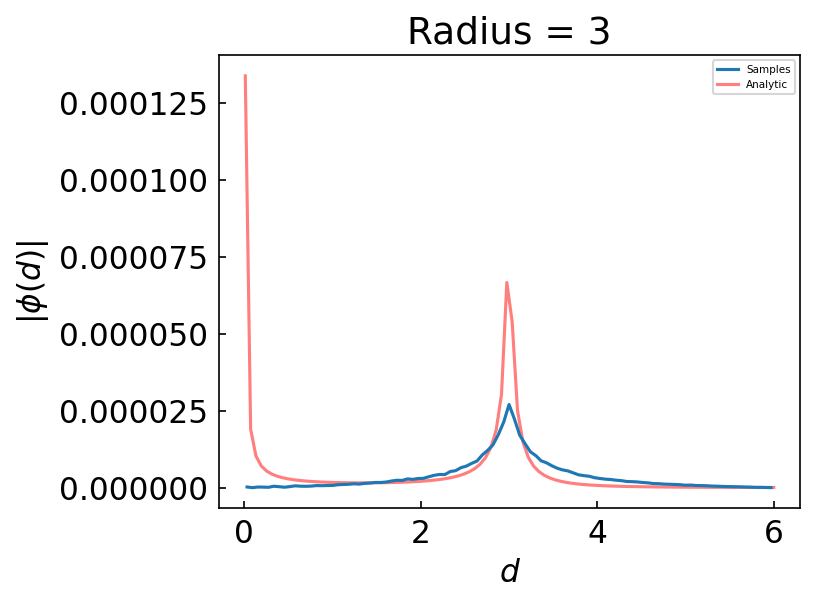

In [23]:
plt.title("Radius = " + str(ri))

plt.plot(xs,np.abs(ys),zorder=1,label="Samples")
offset = int((2/100) * nbins)
offset = 0
phi_xs = np.linspace(0.01,ri + a,100)
phi_ys = contributions(ri,c,phi_xs)

position = pd.DataFrame(np.array([[ri,0,0]]),columns=["x","y","z"])
analytic = np.abs(sim.halos.Analytic.NFW(position,c=c)[0])

plt.plot(phi_xs,analytic * phi_ys/np.sum(phi_ys),color="red",alpha=0.5,zorder=0,label="Analytic")
plt.xlabel(r"$d$")
plt.ylabel(r"$|\phi(d)|$")
plt.legend()
plt.show()